## ECG Signal Analysis: From Acquisition to Processing

### Introduction to ECG
Electrocardiography (ECG) measures electrical signals produced by heart. This notebook will guide you through:

- Collecting heart signals in real-time
- Understanding raw ECG data
- Cleaning up the signals
- Analyzing heart rate and heartbeats

### Getting Ready
First, we need some Python libraries. If you haven't installed them yet, run this command in your terminal:
```
pip install -r requirements.txt
```
Then, these libraries can be imported.

In [65]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from helper.chords_usb import Chords_USB
from IPython.display import display, clear_output
import neurokit2 as nk
import plotly.graph_objects as go
import pandas as pd
import scipy.signal as signal
from pyqtgraph.Qt import QtWidgets, QtCore

#### Here, the data streaming starts.

In [67]:
# This cell initializes the Chords_USB client, checks for compatible hardware, and starts the data streaming process.
client = Chords_USB()

if not client.detect_hardware():
    raise Exception("Could not detect compatible hardware")

client.send_command('START')
print("Streaming started...")

Trying COM25 at 230400...
NPG-LITE detected at COM25 with baudrate 230400
Streaming started...


### Getting Connected
#### Setting Up the Hardware
We'll connect to our device through a USB cable. Some devices can also connect wirelessly.

**Pro Tip:** For better signals:
1. Clean the skin with alcohol swab.

For more information checkout [skin prepration guide section](https://docs.upsidedownlabs.tech/guides/usage-guides/skin-preparation/index.htm) on documentation site.

2. Place electrodes like this:

<img src="assets/ecg.png" alt="Electrode Placement" width="200">

### Collecting Heart Signals
Let's record 15 seconds of heart signals! During this time:
- Try sitting relax.
- Try sitting away from DC Appliances.

**Settings:**
- Recording time: 15 seconds
- Sampling rate: 250/500 Hz depending on the development board
- Smooth animation: 5 updates per second

You'll see a live graph of your heart's electrical activity

### Raw ECG Signal
The first graph shows unfiltered heart signals - it will look wiggly because of natural electrical noise.

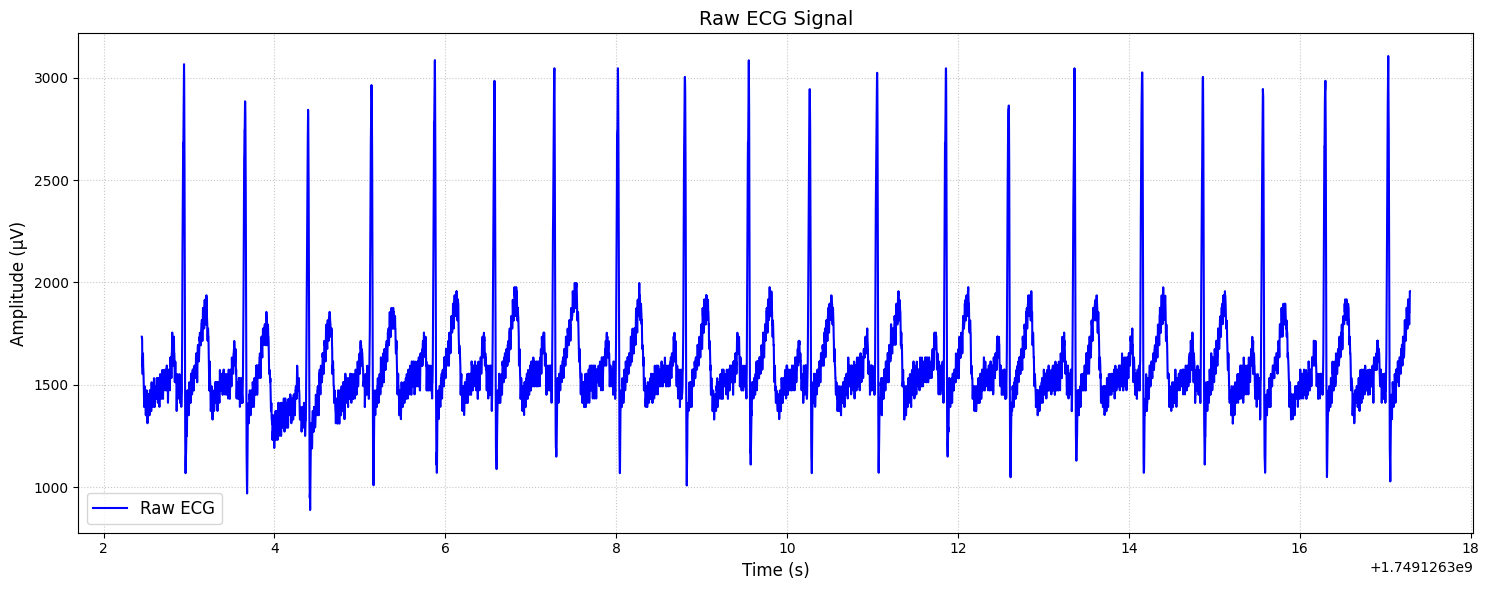

In [68]:
# This cell configures real-time ECG data acquisition, sets up a live plotting window, and continuously updates the display with incoming data for a specified duration.
duration = 15             # Duration for real-time data collection
sampling_rate = client.supported_boards[client.board]["sampling_rate"]
samples_per_update = 100  # Number of samples to add each update
frames_per_second = 5     # 200ms (5 FPS)
update_interval = 1 / frames_per_second  # Update interval in seconds
window_seconds = 15       # seconds to display
window_samples = int(window_seconds * sampling_rate)
time_data = np.array([])
ecg_data = np.array([])

# Set up interactive mode for window display only
%matplotlib qt5
plt.ion()

fig_window, ax_window = plt.subplots(figsize=(12, 6))    # Create figure for separate window only
fig_window.canvas.manager.window.setWindowTitle('Real-time ECG Acquisition')

win = fig_window.canvas.manager.window
win.setWindowFlags(win.windowFlags() | QtCore.Qt.WindowStaysOnTopHint)
win.show()

# Configure plot
ax_window.set_title('Real-time ECG Signal')
ax_window.set_xlabel('Time (s)')
ax_window.set_ylabel('Amplitude')
ax_window.grid(True)
ax_window.set_ylim(0, 5000)

plt.tight_layout()

line_window, = ax_window.plot([], [], 'b-')   # Create line for plot

start_time = time.time()
last_update = start_time

# Real-time acquisition loop
while time.time() - start_time < duration:
    client.read_data()
    
    if client.data is not None:
        new_samples = client.data[0, :]
        current_time = time.time()
        if current_time - last_update >= update_interval:
            samples_to_take = min(samples_per_update, len(new_samples))
            if samples_to_take > 0:
                new_ecg = new_samples[-samples_to_take:]
                new_time = np.linspace(current_time - samples_to_take/sampling_rate, current_time, samples_to_take, endpoint=False)
                
                valid_mask = np.isfinite(new_ecg)     # Remove any NaN or inf values
                new_ecg = new_ecg[valid_mask]
                new_time = new_time[valid_mask]
                
                if len(new_ecg) > 0:  # Only proceed if we have valid data
                    time_data = np.concatenate((time_data, new_time))
                    ecg_data = np.concatenate((ecg_data, new_ecg))
                    
                    valid_mask = np.isfinite(ecg_data) & np.isfinite(time_data)   # Remove any NaN/inf that might have been in existing data
                    ecg_data = ecg_data[valid_mask]
                    time_data = time_data[valid_mask]
                    
                    cutoff_time = current_time - window_seconds
                    keep_mask = time_data >= cutoff_time
                    time_data = time_data[keep_mask]
                    ecg_data = ecg_data[keep_mask]
                    
                    if len(time_data) > 0 and len(ecg_data) > 0:
                        relative_time = time_data - start_time
                        
                        line_window.set_data(relative_time, ecg_data)
                        ax_window.set_xlim(max(0, relative_time[-1] - window_seconds), max(window_seconds, relative_time[-1]))
                        fig_window.canvas.draw()
                        fig_window.canvas.flush_events()
                
                last_update = current_time

plt.close(fig_window)
plt.ioff()

# Plot raw data
%matplotlib inline
plt.figure(figsize=(15, 6))
plt.plot(time_data, ecg_data, 'b-', linewidth=1.5, label='Raw ECG')
plt.title('Raw ECG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### ECG Signal Processing - Cleaning Up the Signal
We use special filters to clean up the data:
- **Notch Filter** - Removes electrical interference (50/60Hz)
- **Low-Pass Filter** - Smooths out the signal

#### CSV File
Then, at the end the data is saved as CSV File in the csv folder with file name ecg_data.

Filtered data saved as 'csv\ecg_data.csv'


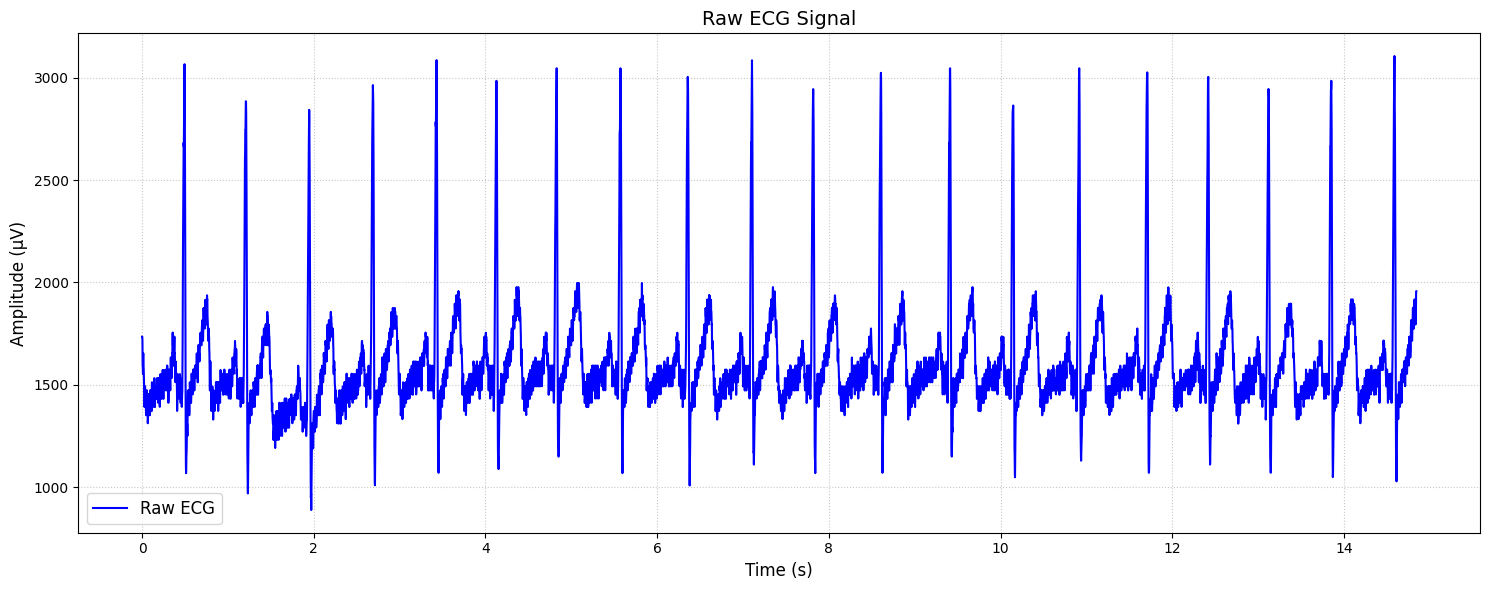

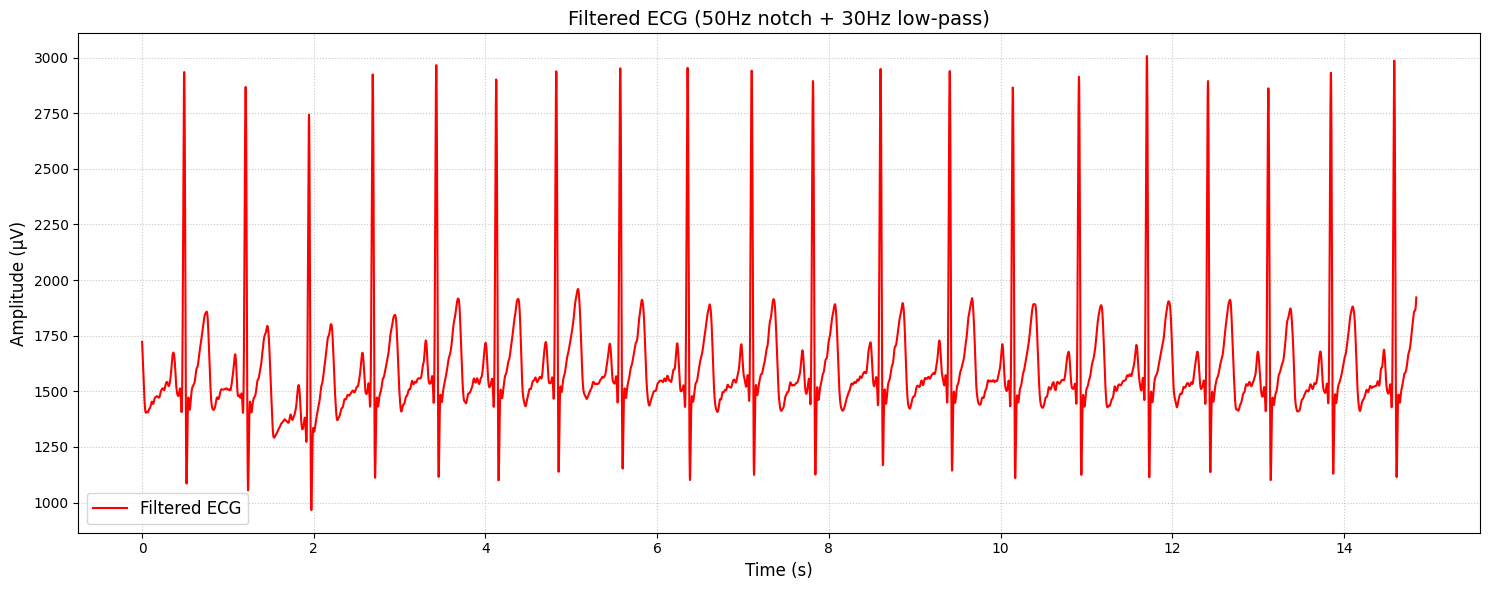

In [69]:
# This cell processes the acquired ECG data by applying notch and low-pass filters, saves the results to a CSV file, and visualizes both raw and filtered signals.
%matplotlib inline
time_axis = time_data - start_time

def notch_filter(data, fs, freq=50.0, quality_factor=30.0):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = signal.iirnotch(freq, quality_factor)
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, fs, cutoff=30.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)

# Apply filters
ecg_notch = notch_filter(ecg_data, sampling_rate, freq=50.0)
ecg_filtered = lowpass_filter(ecg_notch, sampling_rate, cutoff=30.0)

ecg_df = pd.DataFrame({'Time (s)': time_axis,'Raw_ECG': ecg_data,'Notch_Filtered_50Hz': ecg_notch,'LowPass_Filtered_30Hz': ecg_filtered})

# Save to CSV
output_folder = 'csv'
os.makedirs(output_folder, exist_ok=True)
csv_filename = os.path.join(output_folder, 'ecg_data.csv')
ecg_df.to_csv(csv_filename, index=False)
print(f"Filtered data saved as '{csv_filename}'")

# Plot raw signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, ecg_data, 'b-', linewidth=1.5, label='Raw ECG')
plt.title('Raw ECG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot filtered signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, ecg_filtered, 'r-', linewidth=1.5, label='Filtered ECG')
plt.title('Filtered ECG (50Hz notch + 30Hz low-pass)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Heart Rate Analysis
Finding Heartbeats
- We detect R-peaks (the tallest spikes in ECG) to calculate heart rate.

#### What You'll See
- A graph with red dots marking each heartbeat
- Your calculated heart rate in BPM (beats per minute)

In [70]:
# ECG Analysis Pipeline using NeuroKit2
ecg_signal = ecg_filtered

# Step 1: Clean ECG signal using NeuroKit's preprocessing
try:
    ecg_signal = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method="neurokit")
except Exception as e:
    print(f"ECG cleaning failed: {e}")

# Step 2: R-peak detection for heart rate calculation
try:
    peaks = nk.ecg_findpeaks(ecg_signal, sampling_rate=sampling_rate, method="neurokit")
    r_peak_indices = peaks['ECG_R_Peaks']
    print(f"R-peaks detected using neurokit: {len(r_peak_indices)} peaks")

    # Step 3: Heart rate calculation
    if len(r_peak_indices) > 1:
        r_peak_times = time_axis[r_peak_indices]
        rr_intervals = np.diff(r_peak_times)
        heart_rate = 60 / np.mean(rr_intervals)

        print("\nHeart Rate Analysis:")
        print(f"Average Heart Rate: {heart_rate:.2f} BPM")
    else:
        heart_rate = 0
        print("Insufficient R-peaks detected for heart rate calculation")
    
    # Step 4: Visualize results with Plotly
    fig_rpeaks = go.Figure()
    fig_rpeaks.add_trace(go.Scatter(x=time_axis,y=ecg_signal,mode='lines',name='Filtered ECG',line=dict(color='blue')))
    fig_rpeaks.add_trace(go.Scatter(x=time_axis[r_peak_indices],y=ecg_signal[r_peak_indices],mode='markers',name='R-Peaks',marker=dict(color='red', size=8)))
    fig_rpeaks.update_layout(title=f'Filtered ECG with R-Peak Detection (HR: {heart_rate:.1f} BPM)', xaxis_title='Time (s)', yaxis_title='Amplitude')
    fig_rpeaks.show()
    
except Exception as e:
    print(f"R-peak detection failed: {e}")
    r_peak_indices = []

R-peaks detected using neurokit: 20 peaks

Heart Rate Analysis:
Average Heart Rate: 80.89 BPM


### Understanding Heart Waves- The PQRST Complex
Each heartbeat has 5 distinct waves:
- P Wave - Atria contracting (green)
- QRS Complex - Ventricles contracting (red)
- T Wave - Heart relaxing (brown)

In [71]:
# PQRST Complex Analysis- This section analyzes the complete cardiac waveform components (P, QRS, T waves)
if len(r_peak_indices) > 0:
    try:
        # Step 1: ECG Delineation - Identify all waveform components using Discrete Wavelet Transform
        _, delineate = nk.ecg_delineate(ecg_signal, r_peak_indices, sampling_rate=sampling_rate,method="dwt")
        
        # Safe peak extraction with validation
        def get_valid_peaks(peaks):
            if peaks is None:
                return []
            valid_peaks = [int(p) for p in peaks if p is not None and not np.isnan(p)]
            return [p for p in valid_peaks if 0 <= p < len(ecg_signal)]
        
        p_peaks = get_valid_peaks(delineate.get('ECG_P_Peaks', []))
        q_peaks = get_valid_peaks(delineate.get('ECG_Q_Peaks', []))
        s_peaks = get_valid_peaks(delineate.get('ECG_S_Peaks', []))
        t_peaks = get_valid_peaks(delineate.get('ECG_T_Peaks', []))
        
        # Step 2: Select representative complex for visualization
        best_r_idx = r_peak_indices[np.argmax(ecg_signal[r_peak_indices])]
        window_size = int(0.35 * sampling_rate)
        start_idx = max(0, best_r_idx - window_size)
        end_idx = min(len(ecg_signal), best_r_idx + window_size)
        
        # Step 3: Create interactive visualization
        fig_pqrst = go.Figure()
        fig_pqrst.add_trace(go.Scatter(x=time_axis[start_idx:end_idx], y=ecg_signal[start_idx:end_idx], mode='lines', name='Filtered ECG', line=dict(color='blue', width=2)))
        
        def plot_valid_peaks(peaks, name, color): # Enhanced peak plotting with validation
            valid_peaks = [p for p in peaks if start_idx <= p < end_idx]
            if valid_peaks:
                fig_pqrst.add_trace(go.Scatter(x=time_axis[valid_peaks], y=ecg_signal[valid_peaks], mode='markers', name=name, marker=dict(color=color, size=10, line=dict(width=2, color='DarkSlateGrey'))))
        
        plot_valid_peaks(p_peaks, 'P Wave', 'green')
        plot_valid_peaks(q_peaks, 'Q Wave', 'purple')
        plot_valid_peaks([best_r_idx], 'R Peak', 'red')
        plot_valid_peaks(s_peaks, 'S Wave', 'orange')
        plot_valid_peaks(t_peaks, 'T Wave', 'brown')
        
        shapes = []
        for p in p_peaks:
            if start_idx <= p < end_idx:
                shapes.append(dict(type='line', x0=time_axis[p], y0=0, x1=time_axis[p], y1=ecg_signal[p], line=dict(color='green', width=1, dash='dot')))
        
        fig_pqrst.update_layout(title=f'PQRST Complex Analysis (Filtered Data)', xaxis_title='Time (s)', yaxis_title='Amplitude (μV)', hovermode='x unified', showlegend=True, shapes=shapes, height=600, template='plotly_white')
        fig_pqrst.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig_pqrst.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
        
        fig_pqrst.show()
        
    except Exception as e:
        print(f"PQRST delineation failed: {str(e)}")
else:
    print("No R-peaks detected - cannot perform PQRST analysis")

### Beat Morphology
It align all your heartbeats to see their typical shape.

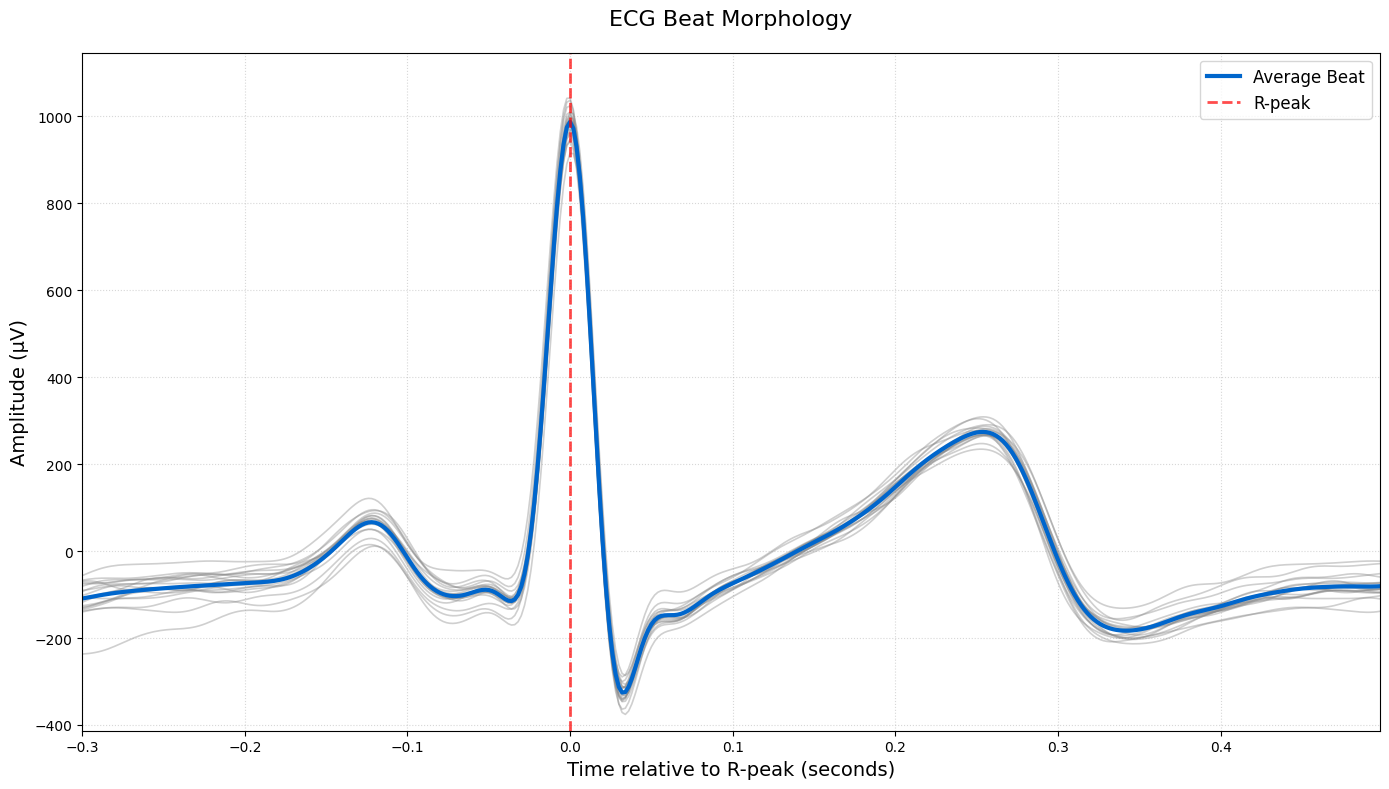

In [72]:
# ECG Beat Morphology Analysis - This cell analyzes and visualizes the shape characteristics of individual heartbeats by aligning them to their R-peaks and computing an average beat.
csv_file = 'csv\\ecg_data.csv'
data = pd.read_csv(csv_file)
ecg_signal = data['LowPass_Filtered_30Hz'].values
sampling_rate = client.supported_boards[client.board]["sampling_rate"]

# Clean ECG and find R-peaks
cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
rpeaks = nk.ecg_findpeaks(cleaned, sampling_rate=sampling_rate)['ECG_R_Peaks']

# Beat segmentation parameters
window_before = int(0.3 * sampling_rate)  # 300ms before R-peak
window_after = int(0.5 * sampling_rate)   # 500ms after R-peak
total_window = window_before + window_after

# Extract and align all beats
beats = []
for peak in rpeaks:
    start = peak - window_before
    end = peak + window_after
    if start >= 0 and end <= len(cleaned):
        beat = cleaned[start:end]
        beats.append(beat)

time_window = (np.arange(total_window) - window_before) / sampling_rate

plt.figure(figsize=(14, 8), dpi=100)
plt.rcParams['lines.linewidth'] = 1.5

# First plot all individual beats (gray background)
for beat in beats:
    if len(beat) == total_window:
        plt.plot(time_window, beat, color='#888888', alpha=0.4, linewidth=1.2)

# Calculate and plot average beat (bold blue)
if len(beats) > 0:
    aligned_beats = [b for b in beats if len(b) == total_window]
    average_beat = np.mean(aligned_beats, axis=0)
    
    plt.plot(time_window, average_beat, color='#0066CC', linewidth=3, alpha=1, label='Average Beat')

all_beats_combined = np.concatenate(beats) if len(beats) > 0 else cleaned
ymin = np.min(all_beats_combined) * 1.1
ymax = np.max(all_beats_combined) * 1.1

plt.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='R-peak')
plt.title('ECG Beat Morphology', fontsize=16, pad=20)
plt.xlabel('Time relative to R-peak (seconds)', fontsize=14)
plt.ylabel('Amplitude (μV)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(fontsize=12, loc='upper right')

plt.ylim(ymin, ymax)
plt.xlim(time_window[0], time_window[-1])

plt.tight_layout()
plt.show()

In [73]:
# Send STOP command to terminate data acquisition
client.send_command('STOP')
print("Streaming stopped")

Streaming stopped


### 📝 Summary & Key Takeaways

#### What We Learned
1. **ECG Basics**: Your heart's electrical activity creates unique waveforms we can measure
2. **Data Collection**: 
   - Proper electrode placement is crucial
   - 15 seconds is enough for basic analysis
3. **Signal Processing**:
   - Raw ECG is noisy but cleanable with filters
   - 50/60Hz noise comes from electrical devices
4. **Heart Analysis**:
   - R-peaks help calculate heart rate
   - Each heartbeat has P Wave, QRS Complex, and T Wave.

#### Key Results
- Your average heart rate: **{heart_rate} BPM**
- Beat morphology shows your heart's unique signature
- Clean data saved to: `csv/ecg_data.csv`

### 🚨 Troubleshooting Guide

**⚠️ No signal?** → Check USB + replug electrodes
**⚠️ Too noisy?** → Alcohol wipe skin + sit still  
**⚠️ Jumpy lines?** → Move away from electronics  
**⚠️ Weak spikes?** → Press electrodes firmly

For more information checkout [guide section](https://docs.upsidedownlabs.tech/guides/troubleshoot/tips/index.html) on documentation site.

### 🔍 Further Exploration

Try these experiments:
1. **Duration change**: Change the duration from 15 to any particular time.
2. **Posture Test**: Compare sitting vs. standing ECGs
3. **Breathing Effect**: Record while holding breath
4. **Exercise Recovery**: Measure after 1 minute of jumping jacks